In [1]:
import random

import gymnasium as gym
import torch
from torcheval.metrics.functional import mean_squared_error

import numpy as np
from scipy.stats import wishart
import matplotlib.pyplot as plt

import sys
sys.path.append('../..')

from tqdm.auto import trange

from src.rlmcmc.utils import Args, KernelRidgeRegression, Toolbox
from src.rlmcmc.env import RLMHEnvV33

In [2]:
log_p = Toolbox.make_log_target_pdf(
    "test-multivariant_normal-test-multivariant_normal",
    "../../posteriordb/posterior_database"
)

In [3]:
# env setup
args = Args()
args.env_id = 'RLMHEnv-v3.3'
args.seed = 1234
args.total_timesteps = 500_000

random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.backends.cudnn.deterministic = args.torch_deterministic

envs = gym.vector.SyncVectorEnv(
    [
        Toolbox.make_env(

            env_id=args.env_id,
            seed=args.seed,
            log_target_pdf=log_p,
            sample_dim=args.sample_dim,
            total_timesteps=args.total_timesteps
        )
    ]
)

_ = envs.reset()

In [4]:
num = int(10_000 / 3)
obs_list_random = np.hstack(
    (
        np.random.uniform(-10.0, 10.0, (num, args.sample_dim)),
        np.random.uniform(-10.0, 10.0, (num, args.sample_dim))
    )
)


action_list_random = wishart.rvs(args.sample_dim, np.eye(args.sample_dim), num << 1).reshape(num, -1)

In [5]:
obs_list_eye = np.hstack(
    (
        np.random.uniform(-10.0, 10.0, (num, args.sample_dim)),
        np.random.uniform(-10.0, 10.0, (num, args.sample_dim))
    )
)

action_list_eye = np.tile(np.eye(2).flatten(), (num, 2))

In [6]:
obs_list_random_eye = np.hstack(
    (
        np.random.uniform(-10.0, 10.0, (num, args.sample_dim)),
        np.random.uniform(-10.0, 10.0, (num, args.sample_dim))
    )
)

action_list_random_eye = (10.0 * np.random.rand(num)).reshape(-1, 1) * np.tile(np.eye(2).flatten(), (num, 2))

In [7]:
obs_list = np.vstack((obs_list_random, obs_list_eye, obs_list_random_eye))
action_list = np.vstack((action_list_random, action_list_eye, action_list_random_eye))

next_obs_list = np.zeros((obs_list.shape[0], args.sample_dim << 1))
rewards_list = np.zeros(obs_list.shape[0])

In [8]:
for i in trange(num):
    envs.set_attr("observation", obs_list[i])
    next_obs, rewards, _, _, _ = envs.step(
                action_list[i:i+1]
            )
    next_obs_list[i:i+1] = next_obs
    rewards_list[i] = rewards.item()

  0%|          | 0/3333 [00:00<?, ?it/s]

In [9]:
design_matrix = np.hstack((obs_list, action_list))

# Kernel Ridge Regression

In [10]:
krr = KernelRidgeRegression(kernel="rbf", lambda_param=0.1, gamma=1.0)
X = torch.from_numpy(design_matrix)
Y = torch.from_numpy(rewards_list)
krr.fit(X, Y)

Y_test = krr.predict(X)

print(mean_squared_error(Y, Y_test))

tensor(0.0460, dtype=torch.float64)


In [11]:
X.requires_grad_(True)

predictions = krr.predict(X)
predictions[0].backward()

gradients = X.grad[0]
gradients

tensor([-3.0039e-04, -7.3933e-04,  8.5817e-05,  6.4573e-06,  9.9549e-04,
        -1.0896e-04, -1.0896e-04, -3.4780e-04, -1.6074e-04,  2.5898e-04,
         2.5898e-04,  1.1374e-06], dtype=torch.float64)

In [12]:
cov_num = 1000
cov_11 = torch.linspace(0.0, 10.0, cov_num).unsqueeze(1)
design_matrix_cov_11 = torch.hstack(
    (
        torch.zeros(cov_num, 4),
        cov_11,
        torch.zeros(cov_num, 2),
        torch.ones(cov_num, 1),
        cov_11,
        torch.zeros(cov_num, 2),
        torch.ones(cov_num, 1),
    )
).double()

cov_22 = torch.linspace(0.0, 10.0, cov_num).unsqueeze(1)
design_matrix_cov_22 = torch.hstack(
    (
        torch.zeros(cov_num, 4),
        torch.ones(cov_num, 1),
        torch.zeros(cov_num, 2),
        cov_22,
        torch.ones(cov_num, 1),
        torch.zeros(cov_num, 2),
        cov_22,
    )
).double()

In [13]:
cov_12 = torch.linspace(-2.0, 2.0, cov_num).unsqueeze(1)
design_matrix_cov_12 = torch.hstack(
    (
        torch.zeros(cov_num, 4),
        2.0 * torch.ones(cov_num, 1),
        cov_12,
        cov_12,
        2.0 * torch.ones(cov_num, 1),
        2.0 * torch.ones(cov_num, 1),
        cov_12,
        cov_12,
        2.0 * torch.ones(cov_num, 1),
    )
).double()

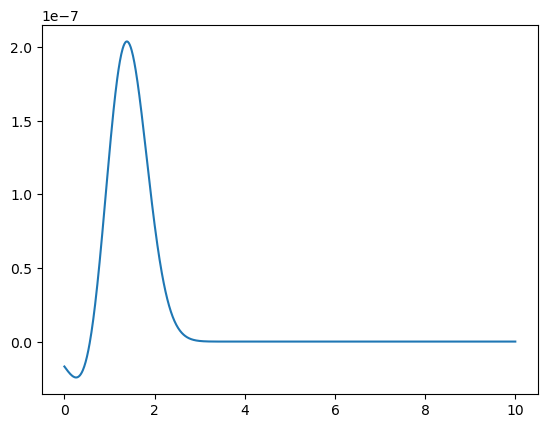

In [14]:
rewards_cov_11 = krr.predict(design_matrix_cov_11).detach().numpy()
plt.plot(cov_11, rewards_cov_11)

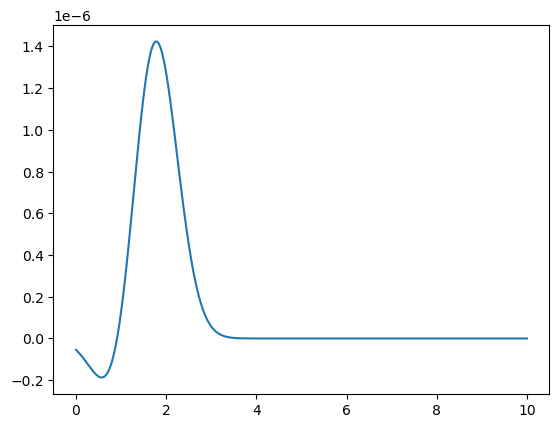

In [15]:
rewards_cov_22 = krr.predict(design_matrix_cov_22).detach().numpy()
plt.plot(cov_22, rewards_cov_22)

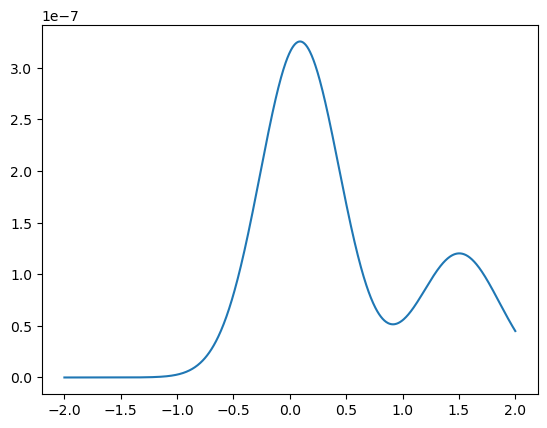

In [16]:
rewards_cov_12 = krr.predict(design_matrix_cov_12).detach().numpy()
plt.plot(cov_12, rewards_cov_12)